# Create Synthetic Image Data - Image Composition
_Viraf Patrawala (May, 2020)_

## STEP 1: Install and Import Required Libraries

Have a look at the import statements below. Install any module you might not already have.

In [195]:
import os
import numpy as np
import skimage.io as io
import skimage.transform as transform
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

## Get the Foreground Image

This is an image of the object class for which you want to generate a synthetic dataset.

#### 1) Create your own foreground image
Download an image from the internet, and cut out the object from it using any tools (for example, Photoshop, GIMP)

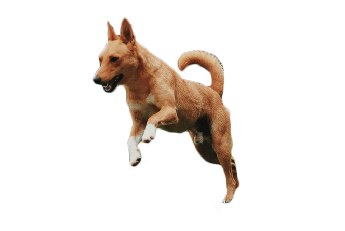

In [231]:
# Read the image
I = io.imread('./dogSeg.jpg')/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

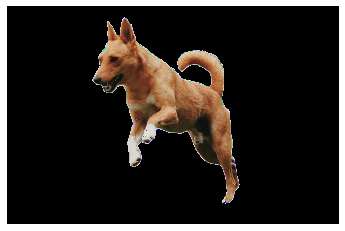

In [250]:
# Get only the foreground
foreground = I.copy()
foreground[foreground>=0.9]=0
plt.axis('off')
plt.imshow(foreground)
plt.show()

#### 2) Get a foreground from an Existing Dataset (COCO)

I am going to use the COCO dataset here to demonstrate. Since COCO already has the object category "dog", it will be easy to get the image and it's mask. The COCO dataset has 4385 (train) and 177 (val) images for the "dog" category.

If you have a problem installing pycocotools, check this [tutorial](https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047).

In [27]:
from pycocotools.coco import COCO

annFile='./instances_val.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [28]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['dog']);
imgIds = coco.getImgIds(catIds=catIds);
print("Number of images containing all filter classes:", len(imgIds))

Number of images containing all filter classes: 177


000000292330.jpg


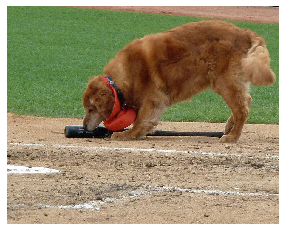

In [32]:
# load and display image
# Keep executing this cell till you get a full dog image

img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img['file_name'])
I = io.imread(img['coco_url'])/255.0
plt.axis('off')
plt.imshow(I)
plt.show()

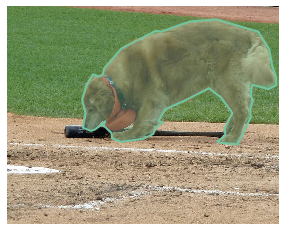

In [70]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

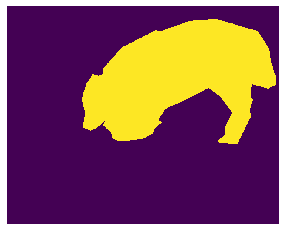

In [169]:
## Get the Binary Mask
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)
plt.axis('off')
plt.show()

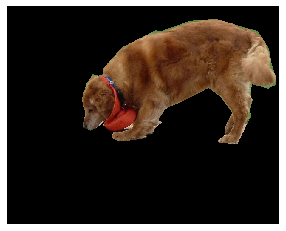

In [179]:
## Generate the foreground 

# Add an extra dimension to the mask
mask = mask.reshape(I.shape[0], I.shape[1], 1)

# Cut out the object from its original image
foreground = mask*I
plt.imshow(foreground)
plt.axis('off')
plt.show()

## Compose the object with a random background

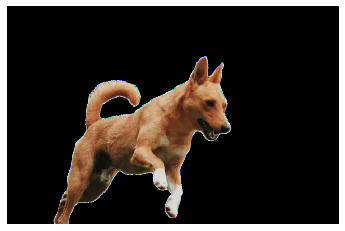

In [233]:
### Apply augmentations on the foreground.

def foregroundAug(foreground):
    # Random rotation, zoom, translation
    angle = np.random.randint(-10,10)*(np.pi/180.0) # Convert to radians
    zoom = np.random.random()*0.4 + 0.8 # Zoom in range [0.8,1.2)
    t_x = np.random.randint(0, int(foreground.shape[1]/3))
    t_y = np.random.randint(0, int(foreground.shape[0]/3))

    tform = transform.AffineTransform(scale=(zoom,zoom),
                                rotation=angle,
                                translation=(t_x, t_y))
    foreground = transform.warp(foreground, tform.inverse)

    # Random horizontal flip with 0.5 probability
    if(np.random.randint(0,100)>=50):
        foreground = foreground[:, ::-1]
        
    return foreground

foreground_new = foregroundAug(foreground)
# Visualize the foreground
plt.imshow(foreground_new)
plt.axis('off')
plt.show()

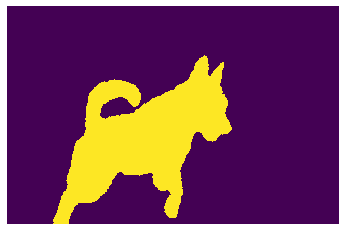

In [234]:
# Create a mask for this new foreground object
def getForegroundMask(foreground):
    mask_new = foreground.copy()[:,:,0]
    mask_new[mask_new>0] = 1
    return mask_new

mask_new = getForegroundMask(foreground_new)
plt.imshow(mask_new)
plt.axis('off')
plt.show()

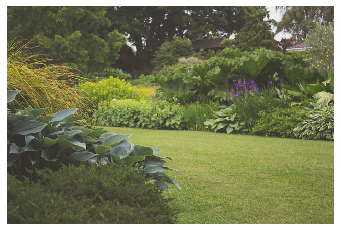

In [239]:
# Random selection of background from the folder
background_fileName = np.random.choice(os.listdir("./backgrounds/"))
background = io.imread('./backgrounds/'+background_fileName)/255.0

# Visualize the background
plt.imshow(background)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


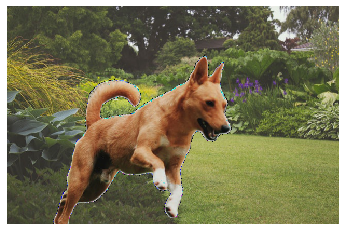

In [240]:
def compose(foreground, mask, background):
    # resize background
    background = transform.resize(background, foreground.shape[:2])

    # Subtract the foreground area from the background
    background = background*(1 - mask.reshape(foreground.shape[0], foreground.shape[1], 1))

    # Finally, add the foreground
    composed_image = background + foreground
    
    return composed_image

composed_image = compose(foreground_new, mask_new, background)
plt.imshow(composed_image)
plt.axis('off')
plt.show()

#### To calculate the bounding box for Object Detection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


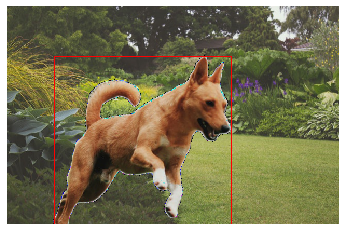

In [251]:
# Get the smallest & largest non-zero values in each dimension and calculate the bounding box
nz = np.nonzero(mask_new)
bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])]

x = bbox[1]
y = bbox[0]
width = bbox[3] - bbox[1]
height = bbox[2] - bbox[0]


# Display the image
plt.imshow(composed_image)

#draw bbox on the image
plt.gca().add_patch(Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none'))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


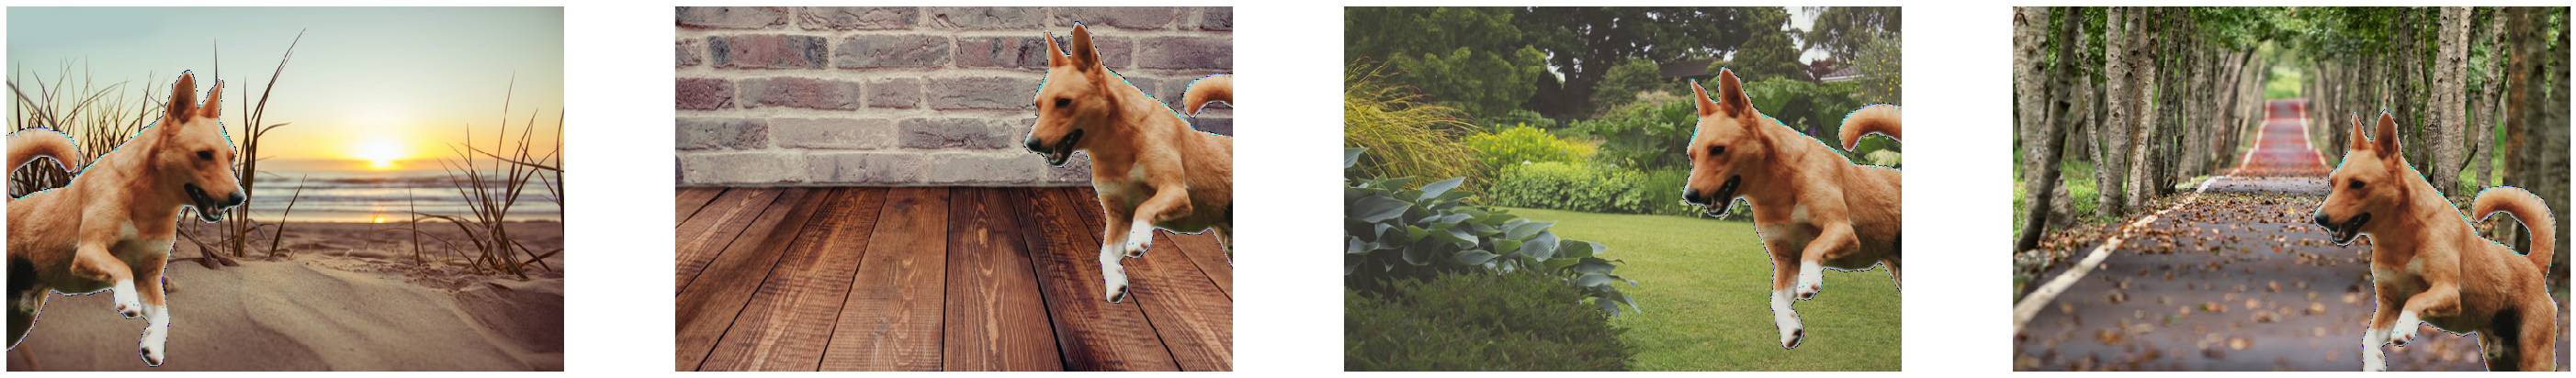

In [253]:
# For visualization
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    foreground_new = foregroundAug(foreground)
    mask_new = getForegroundMask(foreground_new)
    background = io.imread('./backgrounds/' + os.listdir("./backgrounds/")[i])/255.0
    composed_image = compose(foreground_new, mask_new, background)
    axes[i].imshow(composed_image)
    axes[i].set_axis_off()
plt.show()